In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [2]:
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import LiveCryptoData

In [3]:
data = Cryptocurrencies(coin_search = 'USDC', extended_output=False).find_crypto_pairs()
data

Connected to the CoinBase Pro API.
Found 14 instances containing the term USDC.
Extended Output is False, returning reduced dataset.


,id,display_name,fx_stablecoin,max_slippage_percentage,status
32,ADA-USDC,ADA/USDC,False,0.03000000,online
38,USDC-EUR,USDC/EUR,True,0.01000000,online
51,DAI-USDC,DAI/USDC,True,0.01000000,online
111,DNT-USDC,DNT/USDC,False,0.03000000,online
125,CVC-USDC,CVC/USDC,False,0.03000000,online
194,MANA-USDC,MANA/USDC,False,0.03000000,online
234,USDT-USDC,USDT/USDC,True,0.01000000,online
320,LOOM-USDC,LOOM/USDC,False,0.03000000,online
336,USDC-GBP,USDC/GBP,True,0.01000000,online
373,BTC-USDC,BTC/USDC,False,0.03000000,online


In [4]:
period = 60*60*24 #seconds
asset_ls = ['BTC-USD','ETH-USD']
daily_history_df = pd.DataFrame()

for asset in asset_ls:
    daily = HistoricalData(asset, period,'2015-01-01-00-00').retrieve_data()
    daily['ticker'] = asset
    daily_history_df = pd.concat([daily_history_df,daily])

daily_history_df

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2015-01-01T00:00:00
Provisional End: 2015-10-28T00:00:00
Data for chunk 1 of 10 extracted
Provisional Start: 2015-10-28T00:00:00
Provisional End: 2016-08-23T00:00:00
Data for chunk 2 of 10 extracted
Provisional Start: 2016-08-23T00:00:00
Provisional End: 2017-06-19T00:00:00
Data for chunk 3 of 10 extracted
Provisional Start: 2017-06-19T00:00:00
Provisional End: 2018-04-15T00:00:00
Data for chunk 4 of 10 extracted
Provisional Start: 2018-04-15T00:00:00
Provisional End: 2019-02-09T00:00:00
Data for chunk 5 of 10 extracted
Provisional Start: 2019-02-09T00:00:00
Provisional End: 2019-12-06T00:00:00
Data for chunk 6 of 10 extracted
Provisional Start: 2019-12-06T00:00:00
Provisional End: 2020-10-01T00:00:00
Data for chunk 7 of 10 ext

,low,high,open,close,volume,ticker
time,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,BTC-USD
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,BTC-USD
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,BTC-USD
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,BTC-USD
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,BTC-USD
...,...,...,...,...,...,...
2022-06-01,1761.59,1972.50,1940.49,1816.05,266690.708500,ETH-USD
2022-06-02,1780.00,1852.01,1816.06,1832.45,174506.824210,ETH-USD
2022-06-03,1735.79,1842.43,1832.62,1773.25,190669.341541,ETH-USD


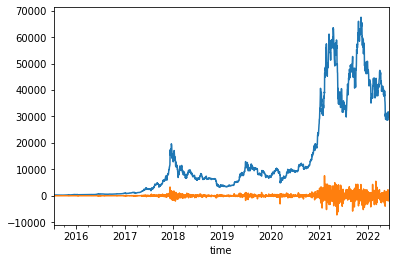

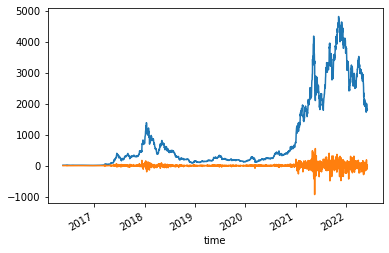

In [5]:
for asset in asset_ls:
    daily_df = daily_history_df[daily_history_df['ticker'] == asset].copy()
    daily_df['returns'] = daily_df['close'] -daily_df['open']
    daily_df['open'].plot()
    daily_df['returns'].plot()
    plt.show()

In [6]:
initial_allocation_ratio = np.array([[.6],[.2],[.1]])

portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)
portfolio_df

,BTC,ETH,USD
time,,,
2016-05-18,0.6,0.2,0.1
2016-05-19,0.6,0.2,0.1
2016-05-20,0.6,0.2,0.1
2016-05-23,0.6,0.2,0.1
2016-05-24,0.6,0.2,0.1
...,...,...,...
2022-06-01,0.6,0.2,0.1
2022-06-02,0.6,0.2,0.1
2022-06-03,0.6,0.2,0.1


In [7]:
def get_daily_return(ticker, time, df=daily_history_df):
    if ticker == 'USD':
        return 1.0
    else:
        df = df.loc[time]
        asset_df = df[df['ticker'].apply(lambda x: ticker in x)]
        return (asset_df['close']/asset_df['open']).values[0]

In [8]:
def calc_asset_daily_returns(row):
    asset_ls = row.index
    time = row.name
    daily_returns_ls = np.array([get_daily_return(asset, time) for asset in asset_ls])
    return daily_returns_ls

In [9]:
def get_random_ratio():
    r_ar = np.random.random((len(asset_ls)+1,1))
    random_portfolio_ratio = r_ar / sum(r_ar)
    if random_portfolio_ratio[-1] > .5: #limit USD ratio to less than half
        return get_random_ratio()
    else:
        return (random_portfolio_ratio * 100).astype(int)/100

In [10]:
asset_daily_returns_df = portfolio_df.apply(lambda x: pd.Series(calc_asset_daily_returns(x),index=portfolio_df.columns), axis=1)
asset_daily_returns_df

,BTC,ETH,USD
time,,,
2016-05-18,1.003016,1.054400,1.0
2016-05-19,0.962288,1.130501,1.0
2016-05-20,1.017675,0.956140,1.0
2016-05-23,1.007278,0.981962,1.0
2016-05-24,1.003209,0.933480,1.0
...,...,...,...
2022-06-01,0.937221,0.935872,1.0
2022-06-02,1.021637,1.009025,1.0
2022-06-03,0.975081,0.967604,1.0


In [11]:
initial_allocation_total_value=1000.00
initial_allocation_ratio=np.array([[.6],[.2],[.1]])
asset_daily_returns_df=asset_daily_returns_df

initial_allocation = initial_allocation_ratio * initial_allocation_total_value 
portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)


return_df = (asset_daily_returns_df).shift(1)
accumulator_df = pd.DataFrame(columns=asset_daily_returns_df.columns,index=asset_daily_returns_df.index)
accumulator_df.iloc[0] = pd.Series(initial_allocation.flatten(),index=asset_daily_returns_df.columns) # initialize portfolio value of first index

shape = accumulator_df.shape[0]
cummulated_returns = (np.cumprod(return_df.shift(-1).values, axis=0)-1)*np.tile(initial_allocation,[shape,1]).reshape(shape, accumulator_df.columns.shape[0]) +\
    np.tile(initial_allocation,[shape,1]).reshape(shape,accumulator_df.columns.shape[0])

accumulator_df.iloc[1:] = pd.DataFrame(cummulated_returns, index=accumulator_df.index).shift(1)
accumulator_df

,BTC,ETH,USD
time,,,
2016-05-18,600,200,100
2016-05-19,601.81,210.88,100
2016-05-20,579.114,238.4,100
2016-05-23,589.35,227.944,100
2016-05-24,593.639,223.832,100
...,...,...,...
2022-06-01,41425.7,33482.3,100
2022-06-02,38825,31335.1,100
2022-06-03,39665.1,31617.9,100


In [12]:
def get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=np.array([[.6],[.2],[.2]]), asset_daily_returns_df=asset_daily_returns_df):

    initial_allocation = initial_allocation_ratio * initial_allocation_total_value 
    portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)
    
    return_df = (asset_daily_returns_df).shift(1)
    accumulator_df = pd.DataFrame(columns=asset_daily_returns_df.columns,index=asset_daily_returns_df.index)
    accumulator_df.iloc[0] = pd.Series(initial_allocation.flatten(),index=asset_daily_returns_df.columns) # initialize portfolio value of first index

    shape = accumulator_df.shape[0]
    cummulated_returns = (np.cumprod(return_df.shift(-1).values, axis=0)-1)*np.tile(initial_allocation,[shape,1]).reshape(shape, accumulator_df.columns.shape[0]) +\
        np.tile(initial_allocation,[shape,1]).reshape(shape,accumulator_df.columns.shape[0])

    accumulator_df.iloc[1:] = pd.DataFrame(cummulated_returns, index=accumulator_df.index).shift(1)

    return accumulator_df

get_accumulated_return(initial_allocation_ratio=np.array([[.6],[.2],[.1]]))

,BTC,ETH,USD
time,,,
2016-05-18,600,200,100
2016-05-19,601.81,210.88,100
2016-05-20,579.114,238.4,100
2016-05-23,589.35,227.944,100
2016-05-24,593.639,223.832,100
...,...,...,...
2022-06-01,41425.7,33482.3,100
2022-06-02,38825,31335.1,100
2022-06-03,39665.1,31617.9,100


[[ 90.]
 [360.]
 [500.]]


,[0.09 0.36 0.5 ]
time,
2016-05-18,950.000000
2016-05-19,969.855472
2016-05-20,1015.987170
2016-05-23,998.701483
2016-05-24,991.944072
...,...
2022-06-01,66981.996141
2022-06-02,62727.011050
2022-06-03,63362.063044


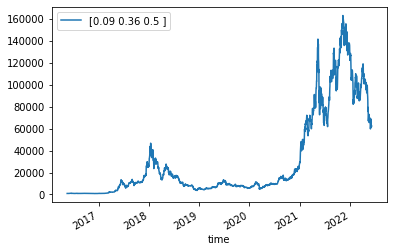

[0.09 0.36 0.5 ]  <lambda>    0.597431
dtype: float64

In [13]:
ratio_ls = [#'BTC','ETH','ADA','USD'
             [[0.09 ],[0.36],[0.5]]
            ]

marker_ls = ['-','-.','x','v']
portfolios = pd.DataFrame()

for i,ratio in enumerate(ratio_ls):
    initial_allocation_ratio = np.array(ratio)
    initial_allocation_total_value = 1000.00
    initial_allocation = initial_allocation_ratio  * initial_allocation_total_value
    print(initial_allocation)
    current_portfolio = get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=initial_allocation_ratio)\
        .sum(axis=1).to_frame().rename(columns={0:str(initial_allocation_ratio.flatten())})
    display(current_portfolio)
    portfolios = pd.concat([portfolios , current_portfolio], axis=1)
portfolios.plot()
plt.show()
agg_period = 90
sharp_calc_df = portfolios.rolling(agg_period).agg([lambda x: (x[-1]-x[0])/np.std(x)])
sharp_df = sharp_calc_df .mean()
display(sharp_df)

[0.09 0.36 0.5 ]  <lambda>    0.597431
dtype: float64


,[0.09 0.36 0.5 ]
count,2208.000000
mean,30032.630454
std,39550.829696
min,858.134248
25%,6229.242924
50%,10510.726310
75%,31578.398364
max,162795.143518


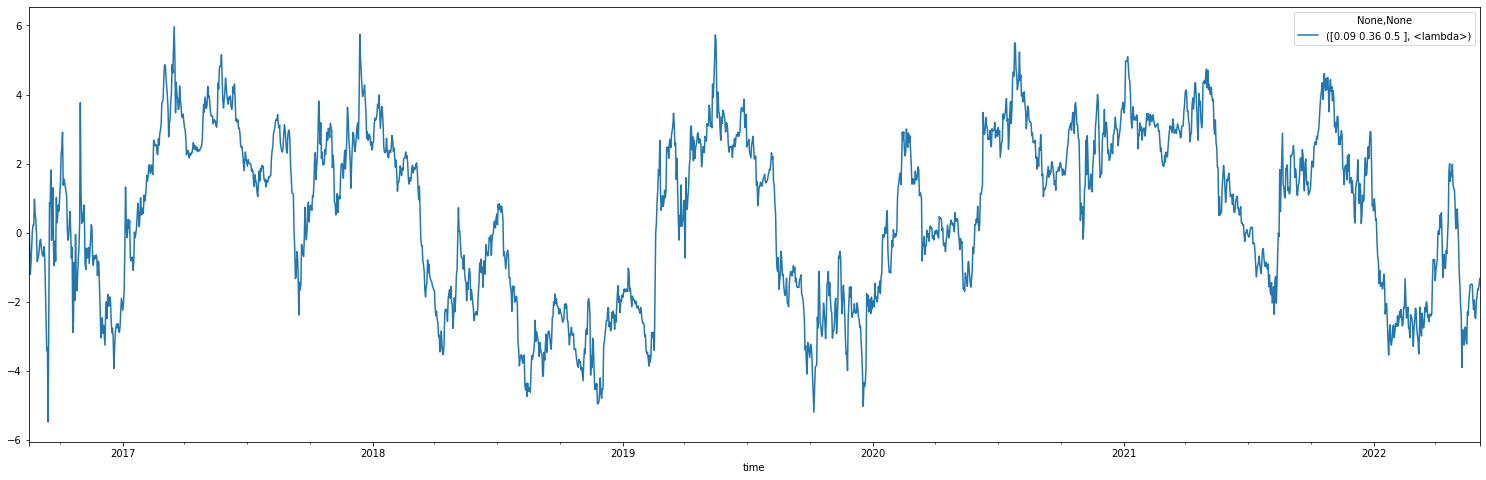

In [14]:
agg_period = 90
sharp_calc_df = portfolios.rolling(agg_period).agg([lambda x: (x[-1]-x[0])/np.std(x)])
sharp_calc_df.dropna().plot(figsize=(26,8))

sharp_df = portfolios.rolling(agg_period).agg([lambda x: (x[-1]-x[0])/np.std(x)]).mean()
print(sharp_df[sharp_df.max()==sharp_df])
portfolios.describe()

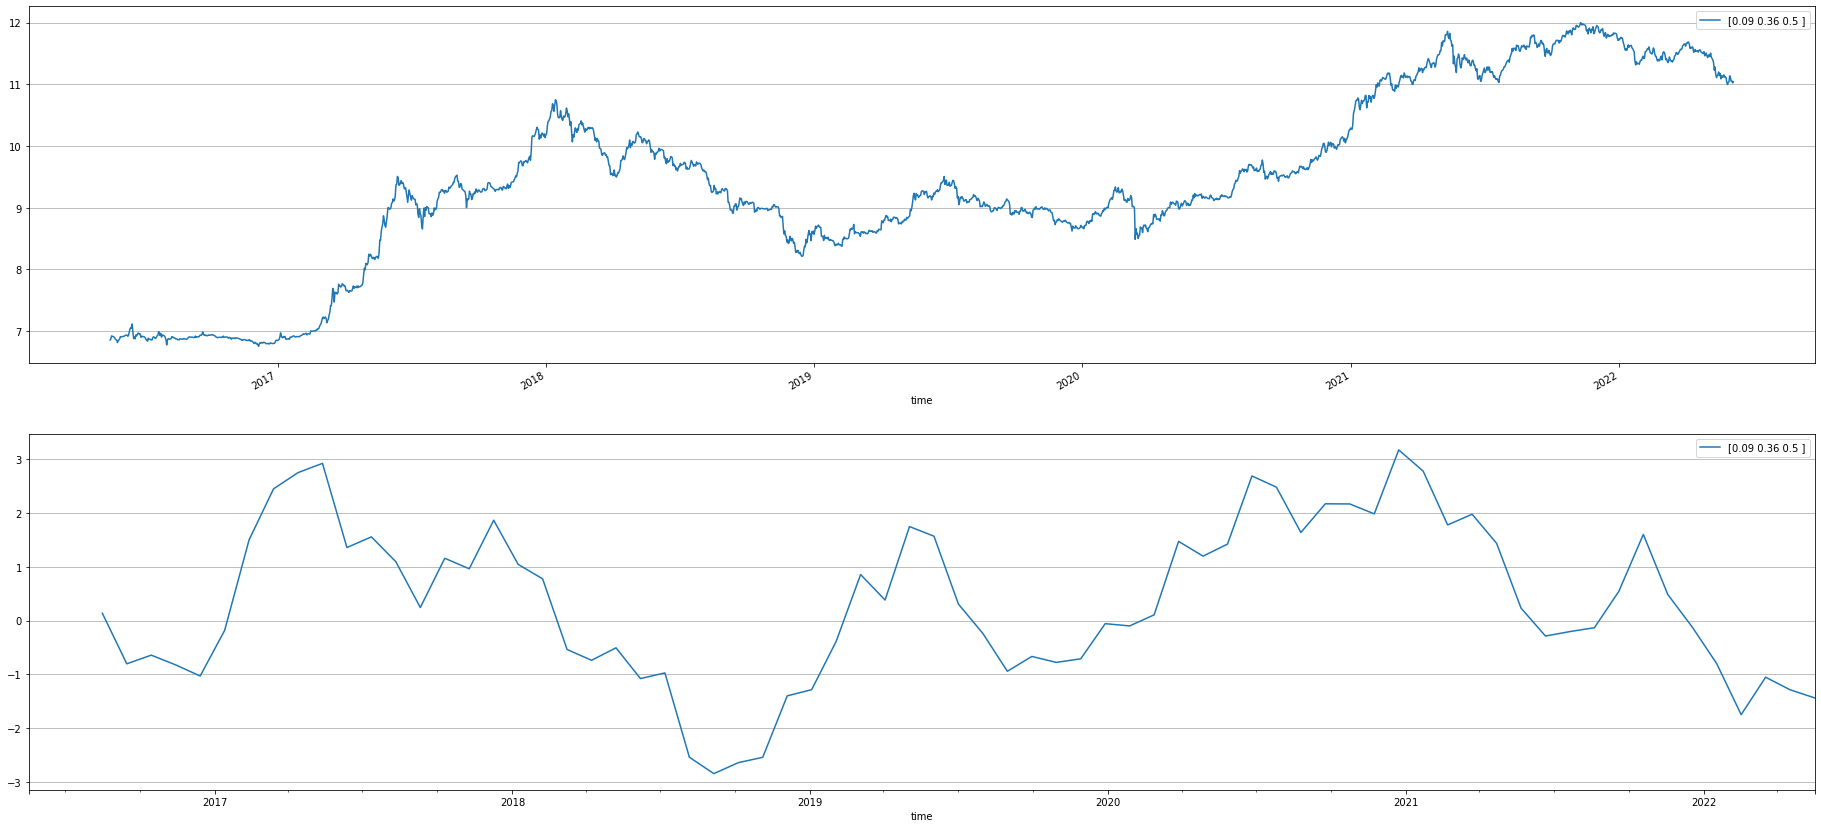

In [15]:
fig, ax = plt.subplots(2,1,figsize=(32,16))
portfolios.apply(lambda x: np.log(x)).plot(ax=ax[0])
portfolios.resample('30d').pipe(lambda df: (df.last() - df.first())/df.std()).rolling(4).mean().plot(ax=ax[1])

ax[0].yaxis.grid()
ax[1].yaxis.grid()

In [16]:
def generate_eval_portfolio(initial_allocation_total_value=1000):
    ratio_ls = [#'BTC','ETH','USD'
                get_random_ratio(),
                ]
   
    for i,ratio in enumerate(ratio_ls):
        initial_allocation_ratio = np.array(ratio)
        initial_allocation = initial_allocation_ratio * initial_allocation_total_value
        
        current_portfolio = get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=initial_allocation_ratio)\
            .sum(axis=1).to_frame().rename(columns={0:str(initial_allocation_ratio.flatten())})
    
    return  current_portfolio.resample('30d').pipe(lambda df: (df.last() - df.first())/df.std()).mean(axis=0)

In [17]:
%%time
for _ in range(1000):
    get_accumulated_return()

CPU times: user 2.61 s, sys: 3.56 ms, total: 2.62 s
Wall time: 2.63 s


### Static portfolio allocation sampling by brute force grid search

In [18]:
%%time
from tqdm import tqdm
from IPython.display import clear_output

best = -np.inf
for i in tqdm(range(int(1e4))):
    best_out_of_4 = generate_eval_portfolio()
    #print(best_out_of_4.values[0] )
    if best_out_of_4.values[0] > best:
        best = best_out_of_4.values[0]
        optimal_ratio = best_out_of_4.index[0]
        clear_output(wait=True)
        print('optimal_ratio', optimal_ratio)
        print('best sharp', best)
        plt.show()

 81%|████████  | 8088/10000 [01:13<00:16, 112.88it/s]

optimal_ratio [0.77 0.21 0.  ]
best sharp 0.5537043711353528


100%|██████████| 10000/10000 [01:30<00:00, 110.95it/s]

CPU times: user 1min 29s, sys: 291 ms, total: 1min 30s
Wall time: 1min 30s


### Dynanmic portfolio allocation thru AI portfolio manager

#### Portfolio rebalancing can be simulated on 30 period with the goal of beating the best static allocation. Timeseries crossvalidation will be implemented to validate/simulate the lack of future performance informatio(eg. ETH outperformed all other assets).

#### Model will output portfolio ratios for each of the 3 assets. The loss function will be best what-if ratio on last 30 day period.

#### First method will be a simple approach with previous portfolio ratio and current portfolio values in \$ info as features to a portfolio mangement model. Output will be the asset ratio of the portfolio. Optimization of the model weight will be based on Genetic Algo based on regularized loss function. Regularization will be based on minimizing allocation changes and even distribution of ratios on assets.

## Use longer term return as fitness function in Genetic Algorithm to opitimize Pytorch NN

In [19]:
def get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=np.array([[.6],[.3],[.1]]), asset_daily_returns_df=asset_daily_returns_df):
    ratio_total = round(initial_allocation_ratio.sum(),6)
    assert ratio_total == 1, f"ratio total is {ratio_total} and doesnt add up to 1"
    initial_allocation = initial_allocation_ratio * initial_allocation_total_value 
    portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)
    
    return_df = (asset_daily_returns_df).shift(1)
    accumulator_df = pd.DataFrame(columns=asset_daily_returns_df.columns,index=asset_daily_returns_df.index)
    accumulator_df.iloc[0] = pd.Series(initial_allocation.flatten(),index=asset_daily_returns_df.columns) # initialize portfolio value of first index

    shape = accumulator_df.shape[0]
    cummulated_returns = (np.cumprod(return_df.shift(-1).values, axis=0)-1)*np.tile(initial_allocation,[shape,1]).reshape(shape, accumulator_df.columns.shape[0]) +\
        np.tile(initial_allocation,[shape,1]).reshape(shape,accumulator_df.columns.shape[0])

    accumulator_df.iloc[1:] = pd.DataFrame(cummulated_returns, index=accumulator_df.index).shift(1)
    return accumulator_df

In [20]:
porfolio_details = get_accumulated_return()
portfolio_value_df = porfolio_details.copy()
portfolio_value_df['total_value'] = porfolio_details.sum(axis=1)

#### reallocating asset back to the ratio

In [21]:
gains_ls = []
adjustment_period = 30 ###ratio redistribution period
porfolio_details = pd.DataFrame()
for i in range(0,asset_daily_returns_df.shape[0]-adjustment_period, adjustment_period):
    current_portfolio_total = initial_allocation_total_value=1000.00 if i==0 else periodic_returns.tail(1).sum(axis=1).values[0]
    periodic_returns = get_accumulated_return(current_portfolio_total, initial_allocation_ratio=np.array([[.6],[.3],[.1]]),
                                        asset_daily_returns_df= asset_daily_returns_df.iloc[i:i+adjustment_period])
    gains_ls+=[(periodic_returns.tail(1).sum(axis=1).values[0],
                asset_daily_returns_df.iloc[i+adjustment_period].name)]
    porfolio_details=porfolio_details.append(periodic_returns.iloc[-1])
    
portfolio_value_df = porfolio_details.copy()
portfolio_value_df['total_value'] = porfolio_details.sum(axis=1)
portfolio_value_df

,BTC,ETH,USD,total_value
2016-06-18,1003.037282,359.865778,100.000000,1462.903060
2016-07-18,780.131106,475.376901,146.290306,1401.798313
2016-08-17,718.621635,434.279058,140.179831,1293.080525
2016-09-16,817.388229,434.388965,129.308052,1381.085246
2016-10-16,869.708395,380.313308,138.108525,1388.130228
...,...,...,...,...
2022-01-18,162372.075285,73425.902881,29930.913498,265728.891663
2022-02-17,165192.117578,78887.740083,26572.889166,270652.746827
2022-03-19,167213.212134,82447.636700,27065.274683,276726.123516
2022-04-18,156067.027460,84088.044008,27672.612352,267827.683820


In [22]:
#### static allocation
display(get_accumulated_return())
get_accumulated_return().iloc[i+30].sum()

,BTC,ETH,USD
time,,,
2016-05-18,600,300,100
2016-05-19,601.81,316.32,100
2016-05-20,579.114,357.6,100
2016-05-23,589.35,341.916,100
2016-05-24,593.639,335.748,100
...,...,...,...
2022-06-01,41425.7,50223.4,100
2022-06-02,38825,47002.7,100
2022-06-03,39665.1,47426.9,100


86914.89179689588

#### A 30 day redistribution strategy Netted over 2x more than static allocation (aka buy and hold)

In [23]:
def generate_row_data(index=0, period=30, portfolio=[600,300,100], allocation_ratio=np.array([[.6],[.3],[.1]])):
    output_portfolio = get_accumulated_return(initial_allocation_total_value=sum(portfolio), initial_allocation_ratio=allocation_ratio, asset_daily_returns_df=asset_daily_returns_df.iloc[index:index+period])
    return output_portfolio.iloc[-1].values.astype(float)

generate_row_data(index=0, period=30, portfolio=[800,300,100], allocation_ratio=np.array([[.6],[.3],[.1]]))

array([1203.6447385 ,  431.83893408,  120.        ])

In [326]:
import torch

# Create the PyTorch model.
input_layer = torch.nn.Linear(3, 8)
relu_layer = torch.nn.ReLU()
hidden_layer1 = torch.nn.Linear(8, 16)
hidden_layer2 = torch.nn.Linear(16, 8)
output_layer = torch.nn.Linear(8, 3)

model = torch.nn.Sequential(input_layer,
                            relu_layer,
                            hidden_layer1,
                            relu_layer,
                            hidden_layer2,
                            relu_layer,
                            output_layer)

In [327]:
import pygad
from pygad import torchga

torch_ga = torchga.TorchGA(model=model,
                                num_solutions=60)

In [328]:
# Data inputs
data_inputs = generate_row_data(index=0, period=30, portfolio=[800,300,100], allocation_ratio=np.array([[.5],[.4],[.1]]))
data_inputs, model(torch.from_numpy(data_inputs).float()), torch.nn.functional.normalize(torch.abs(model(torch.from_numpy(data_inputs).float())), p=1,dim=0)

(array([1003.03728209,  575.78524544,  120.        ]),
 tensor([ 1.8983, -0.8516, -8.3671], grad_fn=<AddBackward0>),
 tensor([0.1708, 0.0766, 0.7526], grad_fn=<DivBackward0>))

In [329]:
np.cumprod(np.array([0.4086, 0.4434, 0.4480]),axis=0)[-1]

0.08116561152000001

In [330]:
def fitness_func(solution, sol_idx):
    global torch_ga, model,  sol_pred, sol_portfolio
    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                         weights_vector=solution)
    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)
    #print(f'{sol_idx} prev_portfolio',prev_portfolio)
    data_inputs = generate_row_data(index=epoch*period, period=period, portfolio=prev_portfolio, allocation_ratio=prev_pred)
    sol_portfolio[sol_idx] = data_inputs
    
    pred = torch.nn.functional.normalize(torch.abs(model(torch.from_numpy(data_inputs).float())),p=1,dim=0).reshape(3,1).detach().numpy()
    #print(pred)
    sol_pred[sol_idx] = pred
    
    updated_pred = generate_row_data(index=epoch*period, period=period, portfolio=prev_portfolio, allocation_ratio=pred) 
    #print(updated_pred)
    
    reg_fact1 = 1e-1
    reg_fact2 = 1e-3
    #fitness function is regularized for portfolio ratio changes and even distribution
    solution_fitness = (updated_pred).sum()*(1-reg_fact1*(np.abs(prev_pred - pred)).sum())*(1-reg_fact2/np.cumprod(pred,axis=0)[-1]) 
    return solution_fitness

In [331]:
def callback_generation(ga_instance):
    global prev_pred, prev_portfolio, epoch, optimized_portfolio, portfolio_values
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print(f"Date {portfolio_value_df.index[epoch]}")
    sol_idx = ga_instance.best_solution()[2]
    prev_pred = sol_pred[sol_idx]
    print(sol_pred[sol_idx].flatten())
    prev_portfolio = sol_portfolio[sol_idx]
    
    current_portfolio = pd.DataFrame([sol_pred[sol_idx].flatten()], columns=['BTC','ETH','USD'], index=[portfolio_value_df.index[epoch]])
    optimized_portfolio = pd.concat([ optimized_portfolio, current_portfolio])
    
    current_portfolio_values = pd.DataFrame([sol_portfolio[sol_idx].flatten()], columns=['BTC','ETH','USD'], index=[portfolio_value_df.index[epoch]])
    portfolio_values = pd.concat([ portfolio_values, current_portfolio_values])
    
    epoch += 1

In [332]:
num_generations = 73 #Each generation is 30 day period weight update based on how well to optimize this current period
num_parents_mating = 5
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

In [333]:
optimized_portfolio = pd.DataFrame()
portfolio_values = pd.DataFrame()

prev_pred = np.array([[.6],[.3],[.1]])
prev_portfolio = np.array([600,300,100])

sol_pred = {}
sol_portfolio = {}

epoch = 0
period = 30

ga_instance.run()

Generation = 1
Fitness    = [1381.5403]
Date 2016-06-18 00:00:00
[0.61508614 0.2860724  0.09884146]
Generation = 2
Fitness    = [1340.8534]
Date 2016-07-18 00:00:00
[0.42359808 0.3605853  0.21581662]
Generation = 3
Fitness    = [1287.143]
Date 2016-08-17 00:00:00
[0.35015002 0.38288423 0.26696575]
Generation = 4
Fitness    = [1369.9163]
Date 2016-09-16 00:00:00
[0.36290267 0.3893689  0.24772847]
Generation = 5
Fitness    = [1351.2197]
Date 2016-10-16 00:00:00
[0.3670476  0.3624991  0.27045333]
Generation = 6
Fitness    = [1332.916]
Date 2016-11-15 00:00:00
[0.4643737  0.26121533 0.2744109 ]
Generation = 7
Fitness    = [1315.0316]
Date 2016-12-15 00:00:00
[0.5031141  0.2220686  0.27481732]
Generation = 8
Fitness    = [1432.9269]
Date 2017-01-14 00:00:00
[0.47299877 0.28641406 0.24058719]
Generation = 9
Fitness    = [1642.65]
Date 2017-02-13 00:00:00
[0.49547586 0.2821669  0.22235724]
Generation = 10
Fitness    = [3135.2827]
Date 2017-03-15 00:00:00
[0.10516675 0.72104824 0.1737851 ]
Gen

In [334]:
prev_portfolio, prev_portfolio.sum()

(array([36227.46386023, 70522.28568866, 72531.546875  ]), 179281.29642389138)

### Dynamic portfolio management can beat static allocation did not beat 30 day reallocation based on static ratio 

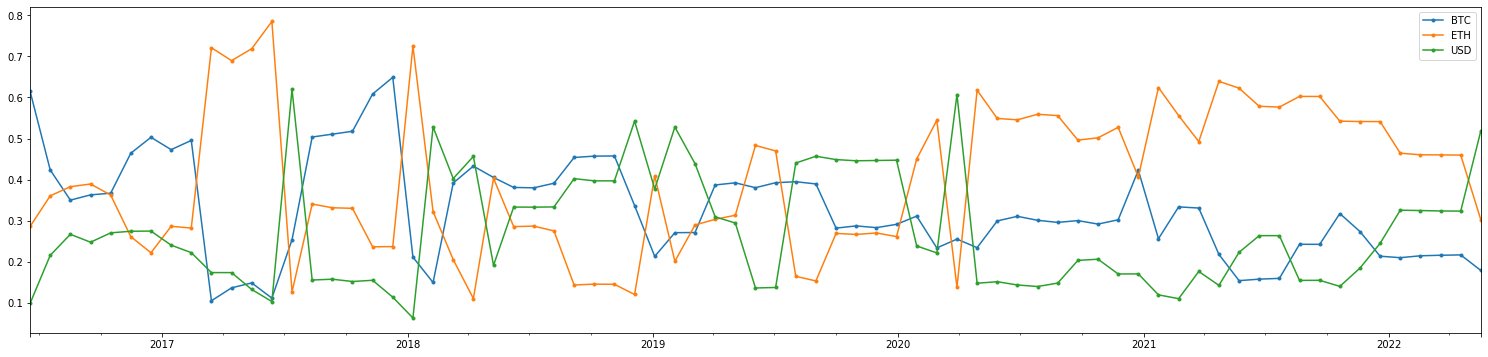

In [335]:
optimized_portfolio.plot(style='.-', figsize=(26,6))

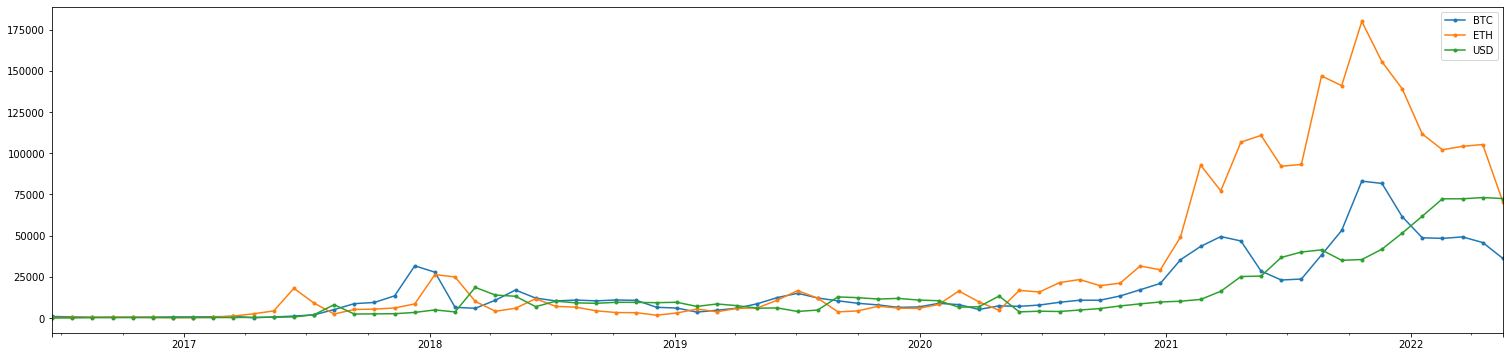

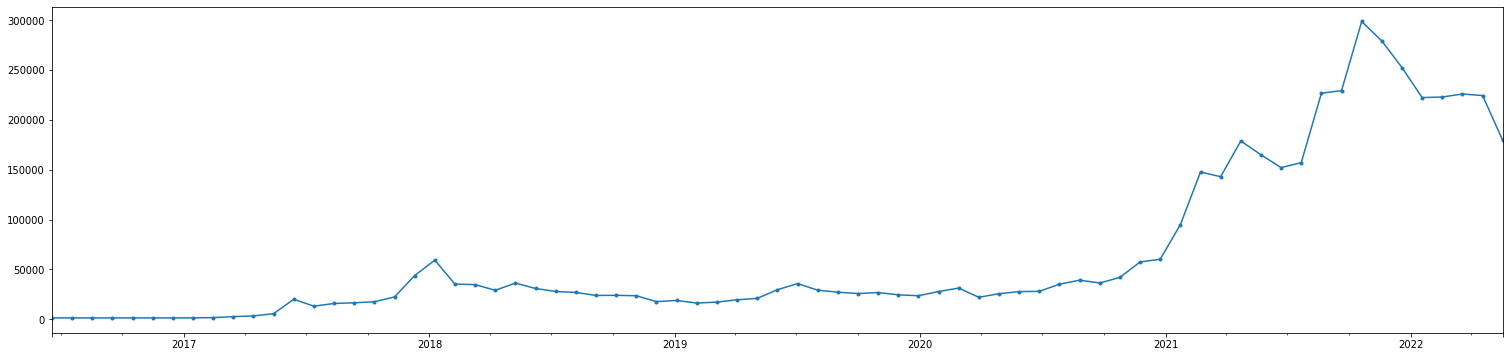

In [336]:
portfolio_values.plot(style='.-', figsize=(26,6))
portfolio_values.sum(axis=1).to_frame().plot(legend=False, style='.-', figsize=(26,6))